# Skin cancer - malign vs belign

In [221]:
%matplotlib inline
import utils; reload(utils)
from utils import *
import numpy as np

In [222]:
path =  '/Users/marcio.dossantos/datasets/'
dataset_path = path + 'ISIC/ISIC-2017_Training_Data/'
sample_dataset_path = path + 'ISIC-sample/ISIC-2017_Training_Data/'

from numpy import genfromtxt
metadata = genfromtxt(isic_path + 'ISIC-2017_Training_Part3_GroundTruth.csv', 
                     skip_header= True,
                     delimiter=',',
                     dtype=[('image_id','S12'),('melanoma','i1'),('seborrheic_keratosis','i1')])

## Creating a sample dataset

In [223]:
np.random.shuffle(metadata)
sample_metadata = metadata[:]

In [224]:
import shutil
import os

def copy_images(line, set_folder):
    directory = sample_dataset_path + set_folder
    if not os.path.exists(directory): os.makedirs(directory)
    if not os.path.exists(directory + 'benign/'): os.makedirs(directory + 'benign/')
    if not os.path.exists(directory + 'malign/'): os.makedirs(directory + 'malign/')
        
    for image_id, melanoma, seborrheic_keratosis in line : 
        image_class = 'benign/' if melanoma == 0 else 'malign/'
        image_filename = image_id + '.jpg'
        pixel_filename = image_id + '_superpixels.png'

        shutil.copy(dataset_path + image_filename, directory + image_class + image_filename)

        # only working with the original picture for now
        # shutil.copy(dataset_path + pixel_filename, directory + image_class + pixel_filename)    

half_idx = len(sample_metadata)/2
three_quarters_idx = 3*len(sample_metadata)/4

copy_images(sample_metadata[:half_idx], 'train/')
copy_images(sample_metadata[half_idx:three_quarters_idx], 'valid/')
copy_images(sample_metadata[three_quarters_idx:], 'test/')

In [225]:
len(sample_metadata[:half_idx])

1000

Let's set sample path and metada as default.

In [226]:
dataset_path = sample_dataset_path
metadata = sample_metadata

In [227]:
batch_size = 4

## Loading data

In [228]:
def image_generator(dirname, class_mode='categorical') :
    gen = image.ImageDataGenerator()
    return gen.flow_from_directory(dirname, 
                                   target_size=(224, 224), 
                                   shuffle=False, 
                                   batch_size=1,
                                   class_mode=class_mode)

In [229]:
val_batches = image_generator(dataset_path + 'valid')
train_batches = image_generator(dataset_path + 'train')

Found 500 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [230]:
def get_data(path) :
    batches = image_generator(path, class_mode= None)
    return np.concatenate([batches.next() for i in range(batches.samples)])

Keras returns *classes* as a single column, so we convert to one hot encoding

In [231]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [232]:
val_classes = val_batches.classes
trn_classes = train_batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

In [233]:
val_data = get_data(dataset_path + 'valid')
trn_data = get_data(dataset_path + 'train')
val_data.shape

Found 500 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


(500, 3, 224, 224)

In [ ]:
trn_features = vgg.model.predict(trn_data, batch_size=batch_size)
val_features = vgg.model.predict(val_data, batch_size=batch_size)

In [235]:
gen=image.ImageDataGenerator()
trn_batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

## Creating the model

In [ ]:
from vgg16 import Vgg16
vgg = Vgg16()

vgg.model.pop()
for layer in vgg.model.layers: layer.trainable=False

vgg.model.add(Dense(2, activation='softmax'))
opt = RMSprop(lr=0.1)
vgg.model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
vgg.model.fit_generator(trn_batches, samples_per_epoch=trn_batches.n, nb_epoch=1, 
                        validation_data=val_batches, nb_val_samples=val_batches.n)

/Users/marcio.dossantos/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., steps_per_epoch=250, epochs=1, validation_steps=500)`
  


Epoch 1/1
236/250 [===========================>..] - ETA: 19s - loss: 3.0735 - acc: 0.8093

## Plotting results

In [216]:
from utils import plot_confusion_matrix

preds = vgg.model.predict_classes(val_data, batch_size=batch_size)

50/50 [==============================] - 19s    


Found 50 images belonging to 2 classes.
[[ 0 43]
 [ 0  7]]


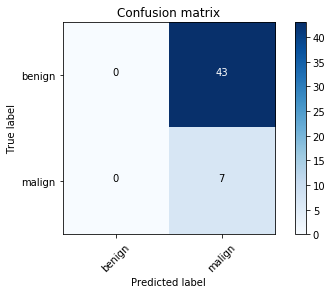

In [217]:
validation_batches = image_generator(dataset_path+'valid/')

cm = confusion_matrix(val_classes, preds)
plot_confusion_matrix(cm, validation_batches.class_indices)